In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np

import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
# plt.style.use('bmh')
import matplotlib.ticker as ticker
import seaborn as sns
import scienceplots
from itertools import accumulate

import torch

In [2]:
import matplotlib.ticker as mticker
def plot_res(save_folder, num_runs, tasks, legends, lr_list, file_name=None, K=None, init_points=None):
    def stack_runs(task, key, lr):
        curves = []
        for r in num_runs:
            if task == "diffusion_distr_est" or task == "diffusion_point_est" or task == "diffusion_distr_est_resample":
                fpath = os.path.join(save_folder, str(r) + "_{}".format(lr), '{}'.format(task))
            else:
                fpath = os.path.join(save_folder, str(r), '{}'.format(task))
            res = torch.load(fpath, weights_only=True)
            values = np.asarray(res[key], dtype=float)
            if key == "total_training_time_list" and "diffusion" in task:
                values = np.fromiter(accumulate(values), dtype=float)

            if K is not None:
                values = values[:K]
            if values.shape[0] == 50:
                curves.append(values)
        return np.stack(curves) 
    
    plt.style.use(["science", "no-latex"])
    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "axes.labelsize": 8,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "axes.linewidth": .6,
        "legend.fontsize": 7,
    })

    metrics = [("train_dfl_losses", "Train DFL loss"),
               ("val_dfl_losses",   "Val DFL loss"),
               ("test_dfl_losses",  "Test DFL loss"),
            #    ("total_training_time_list", "Cumulative training time (s)")
               ]

    ls_pool = ["-", "--", "-.", ":", (0, (1, 1)), (0, (3, 1, 1, 1)),
               (0, (5, 1)), (0, (5, 2, 1, 2)), (0, (2, 2)), (0, (3, 5, 1, 5))]

    num_sub_fig = len(metrics)
    fig, axes = plt.subplots(
        1, num_sub_fig, figsize=(3.25*num_sub_fig, 2.2), dpi=150, sharey=False
    )

    handles_all, labels_all = [], []

    for idx, (key, y_label) in enumerate(metrics):
        ax = axes[idx]

        for i, task in enumerate(tasks):
            data = stack_runs(task, key, lr_list[i])          # (R, E)

            if init_points is not None and key in init_points:
                init_val = float(init_points[key])
                init_col = np.full((data.shape[0], 1), init_val, dtype=float)  # (R, 1)
                data = np.concatenate([init_col, data], axis=1)  # (R, E+1)

            epochs = np.arange(data.shape[1])
            mean, std = data.mean(0), data.std(0)

            h, = ax.plot(epochs, mean,
                         linestyle=ls_pool[i], linewidth=1.0,
                         label=legends[i])
            ax.fill_between(epochs, mean-std, mean+std, alpha=.15)

            if idx == 0:
                handles_all.append(h)
                labels_all.append(legends[i])

        ax.set_xlabel("Epoch")
        ax.set_ylabel(y_label)
        ax.set_xlim(0, 50)
        ax.set_yscale("log", base=2)
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.grid(True, axis="y", linewidth=.3, alpha=.6)
        plt.ticklabel_format(axis='y', style='plain')

    n_items = len(handles_all)
    fig.legend(handles_all, labels_all,
               loc="lower center",
               bbox_to_anchor=(0.5, -0.12),
               ncol=n_items,
               frameon=False,
               handlelength=2,
               columnspacing=1.0,
               fontsize=10)

    fig.tight_layout(pad=.3, rect=[0, 0.06, 1, 1])
    # fig.subplots_adjust(bottom=0.18)
    # save pdf
    plt.savefig(f"{file_name}.pdf", bbox_inches="tight", format="pdf", dpi=300)
    plt.show()


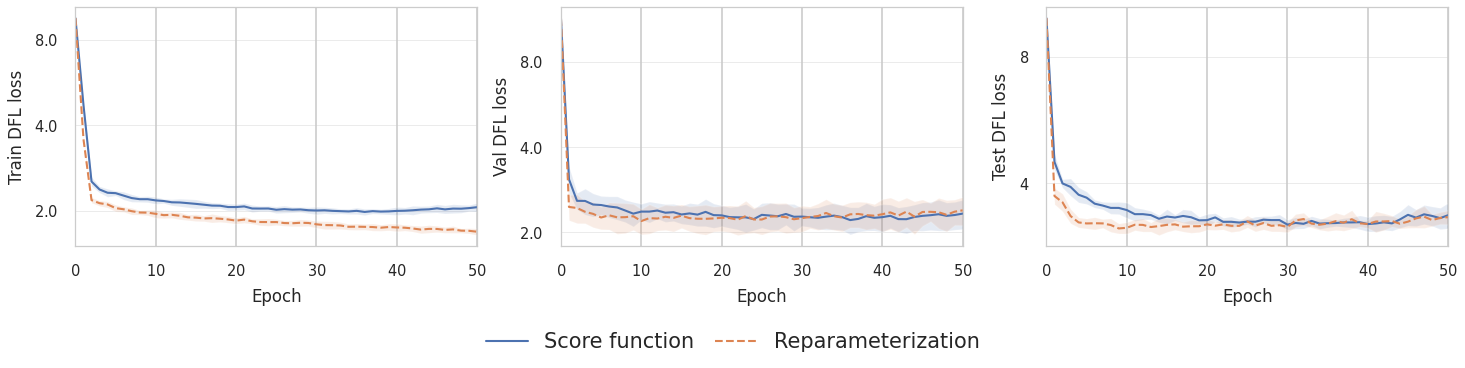

In [ ]:
# tasks = ["diffusion_distr_est", "diffusion_point_est", "task_net_mlp_gaussian_distr", "task_net_mlp_gaussian_reparam", "task_net_deterministic_mlp"]
# legends = ["diffusion sf", "diffusion rp", "Gassuian sf", "Gassuian rp", "MLP"]
tasks = ["diffusion_distr_est", "diffusion_point_est"]
legends = ["Score function", "Reparameterization"]
lr_list = ["5e-06", "8e-06"]

Init_train_DFL = 9.5345
Init_hold_DFL = 11.3900
Init_test_DFL = 9.8865
init_points = {
    "train_dfl_losses": Init_train_DFL,
    "val_dfl_losses":   Init_hold_DFL,
    "test_dfl_losses":  Init_test_DFL,
}

YOUR_HOME_FOLDER = ""
save_folder = os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "power_sched", "power_sched_results_tmp_Jun19_final/")
runs = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
plot_res(save_folder, runs, tasks, legends, lr_list, file_name="diffusion_point_vs_score_fn", init_points=init_points)

In [ ]:
from main import load_data_with_features
import warnings
warnings.filterwarnings("ignore")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
dataset_dir = os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "power_sched/")
X1, Y1 = load_data_with_features(os.path.join(dataset_dir, 'pjm_load_data_2008-11.txt'))
X2, Y2 = load_data_with_features(os.path.join(dataset_dir, 'pjm_load_data_2012-16.txt'))
X = np.concatenate((X1, X2), axis=0)
Y = np.concatenate((Y1, Y2), axis=0)

# Normalize features
X[:,:-1] = (X[:,:-1] - np.mean(X[:,:-1], axis=0)) / np.std(X[:,:-1], axis=0)

# Train, test split
n_tt = int(len(X) * 0.8)
X_train, Y_train = X[:n_tt], Y[:n_tt]
X_test, Y_test = X[n_tt:], Y[n_tt:]

# Construct tensors (without intercepts).
X_train_ = torch.tensor(X_train[:,:-1], dtype=torch.float, device=DEVICE)
Y_train_ = torch.tensor(Y_train, dtype=torch.float, device=DEVICE)
X_test_ = torch.tensor(X_test[:,:-1], dtype=torch.float, device=DEVICE)
Y_test_ = torch.tensor(Y_test, dtype=torch.float, device=DEVICE)
variables_rmse = {'X_train_': X_train_, 'Y_train_': Y_train_, 
            'X_test_': X_test_, 'Y_test_': Y_test_}

th_frac = 0.8
inds = np.random.permutation(X_train.shape[0])
train_inds = inds[ :int(X_train.shape[0] * th_frac)]
hold_inds = inds[int(X_train.shape[0] * th_frac):]
X_train2, X_hold2 = X_train[train_inds, :], X_train[hold_inds, :]
Y_train2, Y_hold2 = Y_train[train_inds, :], Y_train[hold_inds, :]
X_train2_ = torch.tensor(X_train2[:,:-1], dtype=torch.float32, device=DEVICE)
Y_train2_ = torch.tensor(Y_train2, dtype=torch.float32, device=DEVICE)
X_hold2_ = torch.tensor(X_hold2[:,:-1], dtype=torch.float32, device=DEVICE)
Y_hold2_ = torch.tensor(Y_hold2, dtype=torch.float32, device=DEVICE)
variables_task = {'X_train_': X_train2_, 'Y_train_': Y_train2_, 
        'X_hold_': X_hold2_, 'Y_hold_': Y_hold2_,
        'X_test_': X_test_, 'Y_test_': Y_test_}

In [ ]:
from diffusion_opt import Diffsion
x_dim = 149
y_dim = 24

YOUR_HOME_FOLDER = ""
pretrain_diffusion_path = os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "power_sched", "power_sched_results_tmp_Jun19_final/2_5e-06/diffusion_distr_est.pth")
after_pretrain_save_path = os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "power_sched", "power_sched_results_final/0/diffusion_distr_est.pth")

diffusion_timesteps = 300
pretrain_diffusion = Diffsion(x_dim=x_dim, y_dim=y_dim, timesteps=diffusion_timesteps, device=DEVICE)
pretrain_diffusion.model_net.load_state_dict(torch.load(pretrain_diffusion_path, map_location=DEVICE))

after_pretrain_diffusion = Diffsion(x_dim=x_dim, y_dim=y_dim, timesteps=diffusion_timesteps, device=DEVICE)
after_pretrain_diffusion.model_net.load_state_dict(torch.load(after_pretrain_save_path, map_location=DEVICE))

<All keys matched successfully>

In [6]:
from cvxpy_powers_sched_kkt import cvxpy_ps_parallel_kkt
params = {"n": 24, "c_ramp": 0.4, "gamma_under": 50, "gamma_over": 0.5}
mc_samples = 10
layer_sto = cvxpy_ps_parallel_kkt(params, mc_samples=mc_samples)

with torch.no_grad():
    # Diffusion prediction
    pretrain_y_pred_sto = pretrain_diffusion.sample_elbo(X_test_.repeat(mc_samples, 1), test_mode=True)
    pretrain_y_pred_sto = pretrain_y_pred_sto.view(mc_samples, -1, y_dim).permute(1, 0, 2).contiguous()
    pretrain_z_star_sto, _ = layer_sto(pretrain_y_pred_sto)
    pretrain_z_star_sto = pretrain_z_star_sto[0].flatten()

    after_pretrain_y_pred_sto = after_pretrain_diffusion.sample_elbo(X_test_.repeat(mc_samples, 1), test_mode=True)
    after_pretrain_y_pred_sto = after_pretrain_y_pred_sto.view(mc_samples, -1, y_dim).permute(1, 0, 2).contiguous()
    after_pretrain_z_star_sto, _ = layer_sto(after_pretrain_y_pred_sto)
    after_pretrain_z_star_sto = after_pretrain_z_star_sto[0].flatten()
    

In [2]:
sns.set_theme(style="whitegrid", context="talk")
sns.set_palette("colorblind")

def build_df_two_sto(pretrain_z, after_z, z_true, Y_eval, params, f_obj_cubic_no_mean):
    z_pre  = pretrain_z.detach().cpu().numpy().reshape(-1)
    z_post = after_z.detach().cpu().numpy().reshape(-1)
    z_t    = z_true.detach().cpu().numpy().reshape(-1)
    y_np   = Y_eval.detach().cpu().numpy().reshape(-1)

    cost_true = f_obj_cubic_no_mean(z_t, y_np, params).reshape(-1)

    cost_pre  = f_obj_cubic_no_mean(z_pre,  y_np, params).reshape(-1)
    cost_post = f_obj_cubic_no_mean(z_post, y_np, params).reshape(-1)

    df = pd.DataFrame({
        "z_true":   np.concatenate([z_t,    z_t]),
        "z_hat":    np.concatenate([z_pre,  z_post]),
        "cost_true":np.concatenate([cost_true, cost_true]),
        "cost_hat": np.concatenate([cost_pre,  cost_post]),
        "method":   np.array(["Pretrain"]*len(z_t) + ["After"]*len(z_t)),
    })
    df["regret"] = df["cost_hat"] - df["cost_true"]
    return df

def plot_row_three_two_sto(df_long, normalize=True, tie_mode="share", max_points_per_group=2000):

    df2 = df_long.copy()
    df2 = df2[df2["method"].isin(["Pretrain", "After"])].copy()
    df2["idx"] = df2.groupby("method").cumcount()

    fig, axes = plt.subplots(1, 3, figsize=(16, 4.2))

    ax = axes[0]
    sns.histplot(
        data=df2, x="regret", hue="method",
        kde=True, stat="density", common_norm=False,
        alpha=0.35, bins=40, ax=ax
    )
    ax.axvline(0, color="k", ls="--", lw=1)
    ax.set_xlabel(r"Regret  $f(y,\hat z)-f(y,z^*)$")
    ax.set_ylabel("Density")
    ax.set_title("Regret Distribution")
    sns.despine(ax=ax)

    z_true = (df2.loc[df2["method"] == "Pretrain", ["idx", "z_true"]]
                .rename(columns={"z_true": "z"}))
    z_true["which"] = "True"

    z_pre = (df2.loc[df2["method"] == "Pretrain", ["idx", "z_hat"]]
               .rename(columns={"z_hat": "z"}))
    z_pre["which"] = "Pretrain"

    z_post = (df2.loc[df2["method"] == "After", ["idx", "z_hat"]]
                .rename(columns={"z_hat": "z"}))
    z_post["which"] = "After"

    df_z = pd.concat([z_true, z_pre, z_post], ignore_index=True)

    df_z = (df_z.groupby("which", group_keys=False)
                 .apply(lambda g: g.sample(min(len(g), max_points_per_group), random_state=0)))

    ax = axes[1]
    sns.stripplot(
        data=df_z, x="which", y="z",
        order=["True", "Pretrain", "After"],
        jitter=0.25, size=2.2, alpha=0.6, ax=ax
    )
    ax.set_xlabel("")
    ax.set_ylabel(r"$z$")
    ax.set_title(r"$z$ Distribution: True vs Pretrain vs After")
    sns.despine(ax=ax, left=False, bottom=False)

    ax = axes[2]
    wide_cost = (df2.pivot(index="idx", columns="method", values="cost_hat")
                   .reindex(columns=["Pretrain", "After"])
                   .apply(pd.to_numeric, errors="coerce")
                   .dropna(how="any"))

    if tie_mode == "share":
        tol = 1e-8
        row_min = wide_cost.min(axis=1)
        is_min = (wide_cost.sub(row_min, axis=0).abs() <= tol).astype(float)

        weights = is_min.div(is_min.sum(axis=1), axis=0)
        wins = weights.sum(axis=0) 
    else:
        argmins = np.argmin(wide_cost.values, axis=1)
        wins = pd.Series([wide_cost.columns[j] for j in argmins]).value_counts()
        wins = wins.reindex(wide_cost.columns, fill_value=0)

    if normalize:
        wins = wins / wins.sum()
        ylabel = "Win rate"
        fmt = "{:.1%}"
        ax.set_ylim(0, 1)
    else:
        ylabel = "# instances with lower cost"
        fmt = "{:,.0f}"

    sns.barplot(x=wins.index, y=wins.values, ax=ax, edgecolor="black")
    for p, v in zip(ax.patches, wins.values):
        ax.annotate(fmt.format(v),
                    (p.get_x()+p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 3),
                    textcoords="offset points")
    ax.set_ylabel(ylabel)
    ax.set_xlabel("method")
    ax.set_title("Win-rate (lower cost wins)")
    sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()

In [3]:
from cvxpy_powers_sched_kkt import cvxpy_ps_parallel_kkt

def f_obj(z, y, params):
    gamma_under = params["gamma_under"]
    gamma_over = params["gamma_over"]
    return (gamma_under * torch.clamp(y - z, min=0) + 
            gamma_over * torch.clamp(z - y, min=0) + 
            0.5 * (z - y)**2).mean(0)

def comp_true_obj(Y_test, params):    
    layer = cvxpy_ps_parallel_kkt(params, mc_samples=1)

    z_star_tuple, _ = layer(Y_test.unsqueeze(1))
    z_stars_regret = z_star_tuple[0]
    f_evals_regret = f_obj(z_stars_regret, Y_test, params)

    return f_evals_regret, z_stars_regret

In [4]:
f_evals_regret, z_stars_regret = comp_true_obj(Y_test_, params)

NameError: name 'Y_test_' is not defined

In [ ]:
def task_loss_no_mean(Y_sched, Y_actual, params):
    return (params["gamma_under"] * torch.clamp(Y_actual - Y_sched, min=0) + 
        params["gamma_over"] * torch.clamp(Y_sched - Y_actual, min=0) + 
        0.5 * (Y_sched - Y_actual)**2)

def task_loss_no_mean_np(Y_sched, Y_actual, params):
    y_s = np.asarray(Y_sched)
    y_a = np.asarray(Y_actual)
    under = np.clip(y_a - y_s, 0, None)      # (y_a - y_s)_+
    over  = np.clip(y_s - y_a, 0, None)      # (y_s - y_a)_+
    return (params["gamma_under"] * under
            + params["gamma_over"] * over
            + 0.5 * (y_s - y_a)**2)

df_two = build_df_two_sto(
    pretrain_z=pretrain_z_star_sto,
    after_z=after_pretrain_z_star_sto,
    z_true=z_stars_regret,
    Y_eval=Y_test_,
    params=params,
    f_obj_cubic_no_mean=task_loss_no_mean_np
)
plot_row_three_two_sto(df_two, normalize=True, tie_mode="share")


In [8]:
# plot final test comparison
YOUR_HOME_FOLDER = "/nethome/zzhao628/"
save_folder = os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning/Diffusion_DFL", "power_sched", "power_sched_results_final/")
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tasks = ["diffusion_distr_est_resample", "diffusion_point_est", "task_net_mlp_gaussian_distr", "task_net_mlp_gaussian_reparam", "task_net_deterministic_mlp", "policy_learning", "two_stage_diffusion", "two_stage_gaussian", "two_stage_mlp"]
legends = ["df sf", "df rp", "gs sf", "gs rp", "mlp", "policy", "ts df", "ts gs", "ts mlp"]

splits  = ["train", "test"]
metrics = ["rmse", "task"]

records = []
for run in runs:
    run_dir = os.path.join(save_folder, str(run))
    for task in tasks:
        for split in splits:
            for metric in metrics:
                base = f"{task}_{split}_{metric}"
                fpath = os.path.join(run_dir, base)
                if os.path.exists(fpath) and metric == "rmse":
                    value = np.load(fpath)
                elif os.path.exists(fpath) and metric == "task":
                    value = torch.load(fpath, weights_only=False)
                else:
                    raise ValueError(f"File {fpath} does not exist")
                records.append({
                    "run"   : run,
                    "task"  : task,
                    "split" : split,
                    "metric": metric,
                    "value_array" : value,
                    "value_sum"  : value.sum()
                })

len(records)

360

In [9]:
df = pd.DataFrame.from_records(records)
df

,run,task,split,metric,value_array,value_sum
0,0,diffusion_distr_est_resample,train,rmse,"[0.027182326, 0.0322481, 0.03474791, 0.0356869...",1.875063
1,0,diffusion_distr_est_resample,train,task,"[0.027820338, 0.03961154, 0.039737795, 0.03542...",1.845905
2,0,diffusion_distr_est_resample,test,rmse,"[0.035427954, 0.041215457, 0.04452472, 0.04747...",2.835142
3,0,diffusion_distr_est_resample,test,task,"[0.04852345, 0.044112604, 0.046856523, 0.05447...",3.183067
4,0,diffusion_point_est,train,rmse,"[0.031869885, 0.036302652, 0.03999437, 0.03734...",1.963937
...,...,...,...,...,...,...
355,9,two_stage_gaussian,test,task,"[0.100573964, 0.08419156, 0.072996125, 0.07354...",4.680453
356,9,two_stage_mlp,train,rmse,"[0.0222176, 0.024170741, 0.024602719, 0.026139...",1.121956
357,9,two_stage_mlp,train,task,"[0.23499967, 0.28085124, 0.30134585, 0.3395107...",13.479205
358,9,two_stage_mlp,test,rmse,"[0.026465027, 0.028868435, 0.032700635, 0.0364...",2.098923


In [10]:
df["task"]  = pd.Categorical(df["task"],  categories=tasks,  ordered=True)
df["split"] = pd.Categorical(df["split"], categories=splits, ordered=True)

TASK_ORDER = [
    "diffusion_distr_est_resample",
    "diffusion_point_est",
    "task_net_mlp_gaussian_distr",
    "task_net_mlp_gaussian_reparam",
    "task_net_deterministic_mlp",
    "task_net",
    "policy_learning",
    "two_stage_diffusion",
    "two_stage_gaussian",
    "two_stage_mlp",
]
TASK_LABEL = {
    "diffusion_distr_est_resample" : "df sf",
    "diffusion_point_est"        : "df rp",
    "task_net_mlp_gaussian_distr": "gs sf",
    "task_net_mlp_gaussian_reparam": "gs rp",
    "task_net_deterministic_mlp"  : "mlp",
    "task_net"                    : "ori task",
    "policy_learning"             : "policy",
    "two_stage_diffusion"        : "ts df",
    "two_stage_gaussian"         : "ts gs",
    "two_stage_mlp"              : "ts mlp",
}

def bar_scatter(sub_df: pd.DataFrame, title: str, ylabel: str):
    fig, ax = plt.subplots(figsize=(4.6, 2.8), dpi=150)

    stat = (
        sub_df.groupby(["task", "split"])["value_sum"]
              .agg(["mean", "std"])
              .reset_index()
              .rename(columns={"mean": "bar", "std": "err"})
    )
    sns.barplot(
        data=stat, x="task", y="bar", hue="split",
        ax=ax, palette="Set2", capsize=0.15, errwidth=1.0,
        edgecolor="0.3", linewidth=0.4
    )

    sns.stripplot(
        data=sub_df, x="task", y="value_sum", hue="split",
        ax=ax, palette="Set2", dodge=True,
        alpha=0.65, size=3, linewidth=0.4, edgecolor="0.25"
    )

    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    ax.set_xticklabels(
        [TASK_LABEL[t.get_text()] for t in ax.get_xticklabels()],
        rotation=12, ha="right", fontsize=8
    )
    ax.set_title(title, pad=4)
    ax.grid(axis="y", linewidth=.3, alpha=.6)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:len(splits)], labels[:len(splits)],
              title="Split", frameon=False, ncol=3, loc="upper right")
    
    if "Task" in title:
        ax.set_ylim(1, 4)

    # fig.tight_layout(pad=.2)
    plt.show()

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

LIGHT_BLUE  = "#9ecae1"
LIGHT_ORANGE= "#fdd0a2"

def bar_scatter_2(sub_df: pd.DataFrame, title: str, ylabel: str):
    if len(splits) <= 2:
        palette = [LIGHT_BLUE, LIGHT_ORANGE][:len(splits)]
    else:
        extra = sns.color_palette("Greys", n_colors=len(splits)-2)
        palette = [LIGHT_BLUE, LIGHT_ORANGE] + extra

    fig, ax = plt.subplots(figsize=(4.8, 2.9), dpi=150)

    sns.barplot(
        data=sub_df,
        x="task", y="value_sum", hue="split",
        ax=ax, palette=palette, dodge=True,
        estimator=np.mean, errorbar="sd",
        capsize=0.15, errwidth=1.1,
        edgecolor="0.30", linewidth=0.5,
    )

    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    ax.set_title(title, pad=6)
    ax.grid(axis="y", linewidth=.35, alpha=.7)

    ax.set_xticklabels(
        [TASK_LABEL.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()],
        rotation=12, ha="right", fontsize=8.5
    )

    if "Task" in title:
        ax.set_ylim(1, 4)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:len(splits)], labels[:len(splits)],
              title="Split", frameon=False, ncol=min(3, len(splits)),
              loc="upper right")

    sns.despine(ax=ax, top=True, right=True)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2848678/1685848356.py:17: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.barplot(
/tmp/ipykernel_2848678/1685848356.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


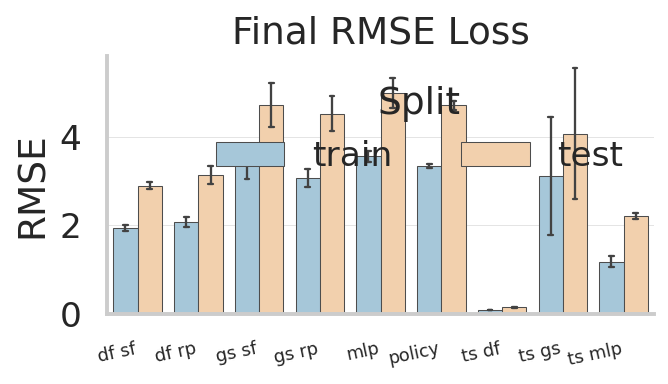

In [12]:
bar_scatter_2(df[df["metric"] == "rmse"],  title="Final RMSE Loss",  ylabel="RMSE")

/tmp/ipykernel_2848678/1685848356.py:17: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.barplot(
/tmp/ipykernel_2848678/1685848356.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


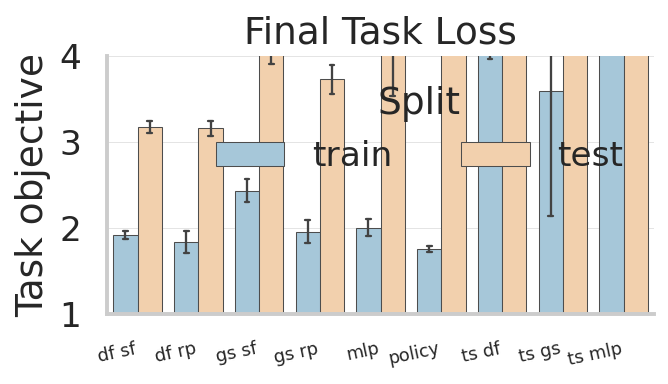

In [13]:
bar_scatter_2(df[df["metric"] == "task"], title="Final Task Loss",  ylabel="Task objective")

/tmp/ipykernel_2848678/3282365578.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2848678/3282365578.py:48: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.0}` instead.

  sns.barplot(
/tmp/ipykernel_2848678/3282365578.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_2848678/3282365578.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2848678/3282365578.py:48: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kw

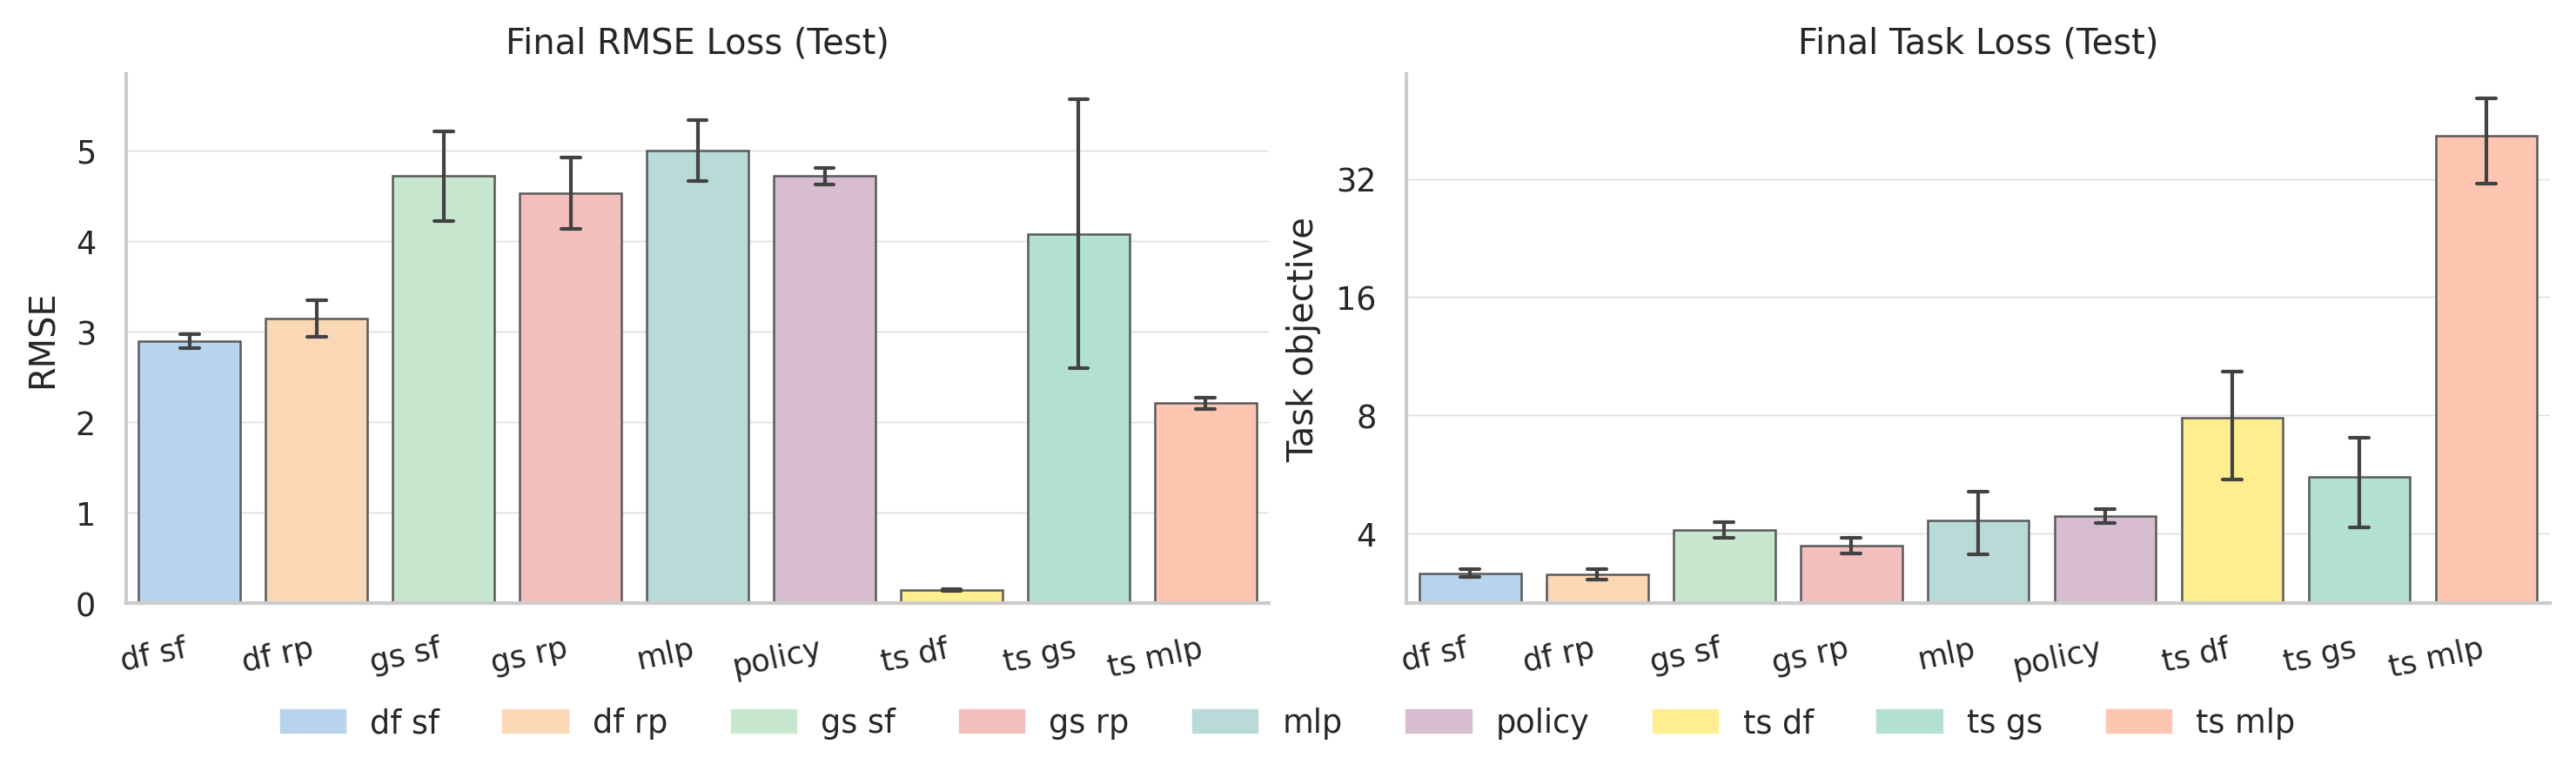

In [14]:
import matplotlib.colors as mcolors
from matplotlib.ticker import LogLocator, FuncFormatter, NullLocator
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

BLUE   = "#6FA8DC"
ORANGE = "#F6B26B"
GREEN  = "#8FD19E"
CORAL  = "#E57F7A"
TEAL   = "#72B7B2"
MAUVE  = "#B279A2"
AMBER  = "#FFDE21"
OKABE_ITO = [BLUE, ORANGE, GREEN, CORAL, TEAL, MAUVE, AMBER]

def lighten_hex(c, amt=0.1):
    rgb = np.array(mcolors.to_rgb(c))
    return mcolors.to_hex((1-amt)*rgb + amt*np.ones_like(rgb))

def build_baseline_palette(categories, base=None, amt=0.1):
    base = (base or OKABE_ITO).copy()
    if len(categories) > len(base):
        base += sns.color_palette("Set2", n_colors=len(categories)-len(base)).as_hex()
    soft = [lighten_hex(c, amt) for c in base]
    return {cat: soft[i] for i, cat in enumerate(categories)}

tasks_all = list(df[df["metric"].isin(["rmse", "task"])]["task"].unique())
BASELINE_COLORS = build_baseline_palette(tasks_all, amt=0.5)


def bar_scatter_ax(sub_df, ax, title: str, ylabel: str, *, logy=False, show_legend=True):
    sub_df = sub_df.copy()

    sub_df = sub_df[~sub_df["split"].str.lower().str.contains("train")]
    lower = sub_df["split"].str.lower()
    if "test" in set(lower.unique()):
        sub_df = sub_df[lower == "test"]
        split_used = "Test"
    elif {"val","valid","validation"} & set(lower.unique()):
        sub_df = sub_df[lower.isin(["val","valid","validation"])]
        split_used = "Val"
    else:
        split_used = None

    tasks_order = list(sub_df["task"].unique())
    palette_for_x = {t: BASELINE_COLORS[t] for t in tasks_order}

    sns.barplot(
        data=sub_df, x="task", y="value_sum",
        ax=ax, order=tasks_order,
        palette=[palette_for_x[t] for t in tasks_order],
        estimator=np.mean, errorbar="sd",
        capsize=0.15, errwidth=1.0,
        edgecolor="0.35", linewidth=0.6,
        saturation=1.0,
        # err_kws={"color": "0.35", "elinewidth": 1.0, "alpha": 0.9}  # 误差棒稍深更清晰
    )

    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    ttl = f"{title}" + (f" ({split_used})" if split_used else "")
    ax.set_title(ttl, pad=6)
    ax.grid(axis="y", linewidth=.35, alpha=.7)

    ax.set_xticklabels(
        [TASK_LABEL.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()],
        rotation=12, ha="right", fontsize=8.5
    )

    if logy:
        ax.set_yscale("log")
    else:
        if "Task" in title:
            ax.set_ylim(1, 4)

    if show_legend:
        import matplotlib.patches as mpatches
        patches = [mpatches.Patch(color=palette_for_x[t], label=TASK_LABEL.get(t, t))
                   for t in tasks_order]
        ax.legend(handles=patches, title="Baseline", frameon=False,
                  ncol=min(4, len(tasks_order)), loc="upper right")
    else:
        if ax.legend_ is not None:
            ax.legend_.remove()

    sns.despine(ax=ax, top=True, right=True)


sns.set_theme(style="whitegrid", context="paper")
fig, axes = plt.subplots(1, 2, figsize=(9.8, 3.0), dpi=300)

bar_scatter_ax(df[df["metric"] == "rmse"],  axes[0], "Final RMSE Loss",  "RMSE",
               logy=False)
bar_scatter_ax(df[df["metric"] == "task"], axes[1], "Final Task Loss",  "Task objective",
               logy=True)
ax = axes[1]
ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2))
ax.yaxis.set_minor_locator(NullLocator())
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}"))

fig.tight_layout(pad=.5, rect=[0, 0.18, 1, 1])

for ax in axes:
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=BASELINE_COLORS[t], label=TASK_LABEL.get(t, t))
           for t in tasks_all]

fig.legend(handles=handles, loc="lower center",
           ncol=max(1, len(handles)), frameon=False,
           bbox_to_anchor=(0.5, 0.03))

fig.subplots_adjust(bottom=0.24)

plt.savefig("power_sched_baselines.pdf", bbox_inches="tight", format="pdf", dpi=300)
plt.show()


In [15]:
df["value_sum"] = pd.to_numeric(df["value_sum"], errors="coerce")

test_df = df[df["split"].str.lower() == "test"].copy()

test_df["label"] = test_df["task"].astype(str).map(lambda t: TASK_LABEL.get(t, t))

stats = (
    test_df.groupby(["metric", "task"], observed=True, as_index=False)["value_sum"]
    .agg(
        mean="mean",
        var=lambda x: x.var(ddof=1),
        std=lambda x: x.std(ddof=1),
        n="size",
    )
)

stats["label"] = stats["task"].astype(str).map(lambda t: TASK_LABEL.get(t, t))

stats = stats[["metric", "task", "label", "mean", "var", "std", "n"]]

out_all = os.path.join(save_folder, "power_sched_baselines_stats.csv")
stats.to_csv(out_all, index=False)
print(f"Saved: {out_all}")

for m in ["rmse", "task"]:
    sub = stats[stats["metric"] == m].drop(columns=["metric"])
    out_m = os.path.join(save_folder, f"power_sched_baselines_stats_{m}.csv")
    sub.to_csv(out_m, index=False)
    print(f"Saved: {out_m}")

print(stats)

Saved: /nethome/zzhao628/e2e-model-learning/Diffusion_DFL/power_sched/power_sched_results_final/power_sched_baselines_stats.csv
Saved: /nethome/zzhao628/e2e-model-learning/Diffusion_DFL/power_sched/power_sched_results_final/power_sched_baselines_stats_rmse.csv
Saved: /nethome/zzhao628/e2e-model-learning/Diffusion_DFL/power_sched/power_sched_results_final/power_sched_baselines_stats_task.csv
   metric                           task   label       mean         var  \
0    rmse   diffusion_distr_est_resample   df sf   2.893890    0.006422   
1    rmse            diffusion_point_est   df rp   3.141259    0.039722   
2    rmse    task_net_mlp_gaussian_distr   gs sf   4.713055    0.242310   
3    rmse  task_net_mlp_gaussian_reparam   gs rp   4.525736    0.154604   
4    rmse     task_net_deterministic_mlp     mlp   4.997710    0.113053   
5    rmse                policy_learning  policy   4.712945    0.009061   
6    rmse            two_stage_diffusion   ts df   0.147249    0.000037   
7    r

In [10]:
def get_test_task_loss(df, baseline="two_stage_diffusion"):
    d = df.copy()
    d["split"] = d["split"].str.lower()

    sub = d[(d["metric"] == "task") &
            (d["task"] == baseline) &
            (d["split"] == "test")]
    if sub.empty:
        sub = d[(d["metric"] == "task") &
                (d["task"] == baseline) &
                (d["split"].isin(["val", "valid", "validation"]))]

    if sub.empty:
        raise ValueError(f"No rows for baseline={baseline!r} with metric='task' (test/val).")

    mean = sub["value_sum"].mean()
    std  = sub["value_sum"].std(ddof=1)
    n    = len(sub)
    return {"mean": float(mean), "std": float(std), "n": int(n),
            "sem": float(std/np.sqrt(n)) if n>0 else np.nan}
out = get_test_task_loss(df, baseline="two_stage_diffusion")
print(f"two_stage_diffusion Test Task Loss: "
      f"mean={out['mean']:.4f}, std={out['std']:.4f}, n={out['n']}")


two_stage_diffusion Test Task Loss: mean=7.9015, std=2.4130, n=10


/tmp/ipykernel_4130878/1199983907.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.barplot(
/tmp/ipykernel_4130878/1199983907.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_4130878/1199983907.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.barplot(
/tmp/ipykernel_4130878/1199983907.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


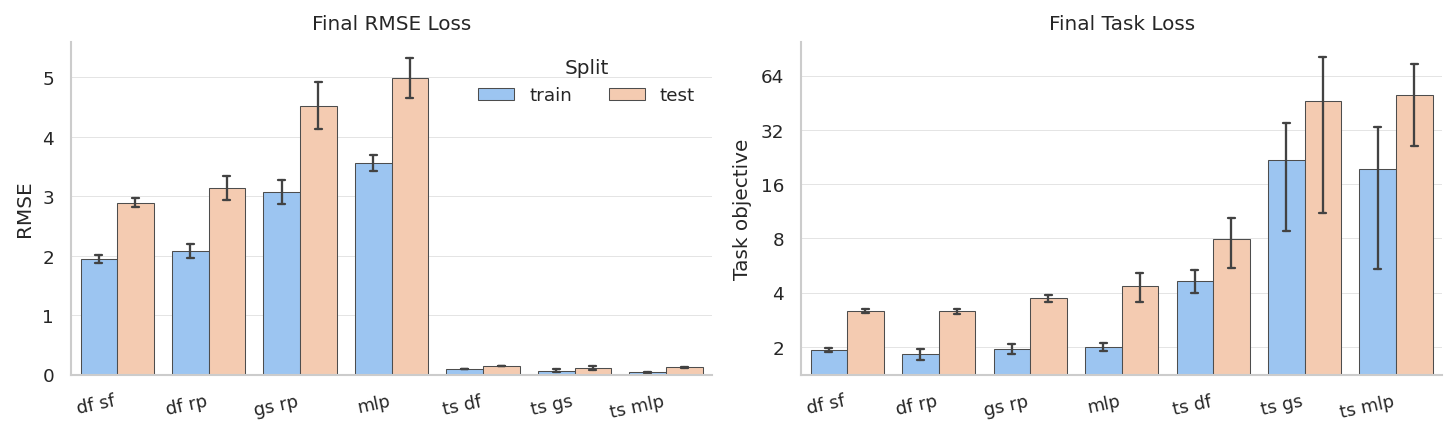

In [11]:
LIGHT_BLUE  = "#8EC5FF"
LIGHT_ORANGE= "#FFC9A6"

def bar_scatter_ax(sub_df, ax, title: str, ylabel: str, *, logy=False, show_legend=True):
    # palette
    if len(splits) <= 2:
        palette = [LIGHT_BLUE, LIGHT_ORANGE][:len(splits)]
    else:
        extra = sns.color_palette("Greys", n_colors=len(splits)-2)
        palette = [LIGHT_BLUE, LIGHT_ORANGE] + extra

    sns.barplot(
        data=sub_df,
        x="task", y="value_sum", hue="split",
        ax=ax, palette=palette, dodge=True,
        estimator=np.mean, errorbar="sd",
        capsize=0.15, errwidth=1.1,
        edgecolor="0.30", linewidth=0.5,
    )

    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    ax.set_title(title, pad=6)
    ax.grid(axis="y", linewidth=.35, alpha=.7)

    ax.set_xticklabels(
        [TASK_LABEL.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()],
        rotation=12, ha="right", fontsize=8.5
    )

    if logy:
        ax.set_yscale("log")
    else:
        if "Task" in title:
            ax.set_ylim(1, 4)

    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:len(splits)], labels[:len(splits)],
                  title="Split", frameon=False, ncol=min(3, len(splits)),
                  loc="upper right")
    else:
        ax.legend_.remove()

    sns.despine(ax=ax, top=True, right=True)

# ---- make the 1x2 figure ----
fig, axes = plt.subplots(1, 2, figsize=(9.8, 3.0), dpi=150)

bar_scatter_ax(df[df["metric"] == "rmse"],  axes[0], "Final RMSE Loss",  "RMSE",
               logy=False, show_legend=True)

bar_scatter_ax(df[df["metric"] == "task"], axes[1], "Final Task Loss",  "Task objective",
               logy=True, show_legend=False)

from matplotlib.ticker import LogLocator, FuncFormatter, NullLocator

ax = axes[1]
ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2))
ax.yaxis.set_minor_locator(NullLocator())

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}"))

plt.tight_layout()
plt.savefig("power_sched_baselines.pdf", bbox_inches="tight", format="pdf", dpi=300)
plt.show()
